# 15. 심층 합성곱 신경망으로 이미지 분류

구성: 여러개의 `합성곱 층`, 학습되는 파라미터가 없는 `풀링 층` (서브 샘플링 층), 하나 이상의 완전 연결 층 - `다층 퍼셉트론 층`  

## 15.1 합성곱 신경망의 구성 요소

### 15.1.2 이산 합성곱 수행

In [1]:
# 1차원 합성곱 구현
import numpy as np
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded)-len(w_rot))/s+1), s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

In [2]:
# 2차원 합성곱 구현
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1, ::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0], p[1]:p[1]+X_orig.shape[1]] = X_orig
    
    res = []
    for i in range(0, int((X_padded.shape[0]-W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1]-W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

## 15.2 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성

### 15.2.2 드롭아웃으로 신경망 규제

In [3]:
# 일단 L2 regularization
from tensorflow import keras
conv_layer = keras.layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

In [4]:
fc_layer = keras.layers.Dense(
    units=16,
    kernel_regularizer=keras.regularizers.l2(0.001))

### 15.2.3 분류를 위한 손실 함수

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
# 이진 크로스 엔트로피 - 이진 분류를 위한 손실함수
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # 확률로 계산 결과가 나옴
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)
tf.print(
    'BCE (확률): {:.4f}'.format(
        bce_probas(y_true=[1], y_pred=probas)),
    '(로짓): {:.4f}'.format(
        bce_logits(y_true=[1], y_pred=logits)))

2022-04-26 23:02:09.741466: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
BCE (확률): 0.3711 (로짓): 0.3711


In [13]:
# 범주형 크로스 엔트로피
cce_probas = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)
tf.print(
    'CCE (확률): {:.4f}'.format(cce_probas(y_true=[[0, 0, 1]], y_pred=probas)),
    '(로짓): {:.4f}'.format(cce_logits(y_true=[[0, 0, 1]], y_pred=logits)))

CCE (확률): 0.5996 (로짓): 0.5996


In [14]:
# 희소 범주형 크로스 엔트로피
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

tf.print('Sparse CCE (확률): {:.4f}'.format(sp_cce_probas(y_true=[2], y_pred=probas)),
         '(로짓): {:.4f}'.format(sp_cce_logits(y_true=[2], y_pred=logits)))

Sparse CCE (확률): 0.5996 (로짓): 0.5996


## 15.3 텐서플로를 사용하여 심층 합성곱 신경망 구현

### 15.3.2 데이터 적재와 전처리

In [1]:
import tensorflow_datasets as tfds

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']

2022-04-27 10:18:04.056258: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# validation set 나누기
import tensorflow as tf

BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32) / 255.0,
                  tf.cast(item['label'], tf.int32))
)
mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32) / 255.0,
                  tf.cast(item['label'], tf.int32))
)
tf.random.set_seed(1)
mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

### 15.3.3 텐서플로 케라스 API를 사용하여 CNN 구현

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5), strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))

model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2'))

In [11]:
# 특성 맵의 크기는?
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [12]:
# 분류를 위해 완전 연결 층에 연결하기
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [13]:
# 두 개 밀집층 + 드롭 아웃 층 추가
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', activation='relu'))

model.add(tf.keras.layers.Dropout(rate=0.5))

model.add(tf.keras.layers.Dense(
    units=10, name='fc_2', activation='softmax'))

In [14]:
# 모델 build -> compile
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [15]:
# fit() on validation set - evaluate () - predict()
history = model.fit(mnist_train, epochs=NUM_EPOCHS,
                    validation_data=mnist_valid,
                    shuffle=True)

Epoch 1/20


2022-04-27 10:44:34.994688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


782/782 [==============================] - 81s 102ms/step - loss: 0.3113 - accuracy: 0.9017 - val_loss: 0.0466 - val_accuracy: 0.9853
Epoch 2/20
782/782 [==============================] - 85s 108ms/step - loss: 0.0483 - accuracy: 0.9853 - val_loss: 0.0413 - val_accuracy: 0.9866
Epoch 3/20
782/782 [==============================] - 83s 105ms/step - loss: 0.0304 - accuracy: 0.9904 - val_loss: 0.0400 - val_accuracy: 0.9885
Epoch 4/20
782/782 [==============================] - 78s 99ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0331 - val_accuracy: 0.9902
Epoch 5/20
782/782 [==============================] - 67s 85ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.0417 - val_accuracy: 0.9890
Epoch 6/20
782/782 [==============================] - 63s 80ms/step - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.0481 - val_accuracy: 0.9879
Epoch 7/20
782/782 [==============================] - 57s 73ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.0408 - val_accuracy: 0.9899


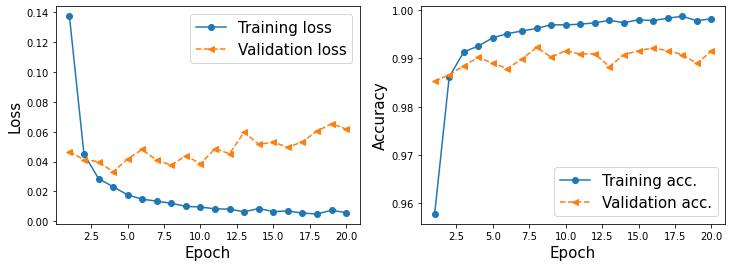

In [17]:
# 학습 곡선 그리기
import matplotlib.pyplot as plt
import numpy as np
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Training loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Training acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [19]:
# evaluate()
test_results = model.evaluate(mnist_test.batch(20))
print('테스트 정확도: {:.2f}%'.format(test_results[1] * 100))

500/500 [==============================] - 4s 8ms/step - loss: 0.0464 - accuracy: 0.9923
테스트 정확도: 99.23%


In [20]:
# 입력과 예측 레이블을 그래프로 그려보기
batch_test = next(iter(mnist_test.batch(12)))
preds = model(batch_test[0])
tf.print(preds.shape)

TensorShape([12, 10])


In [21]:
preds = tf.argmax(preds, axis=1)
print(preds)

tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


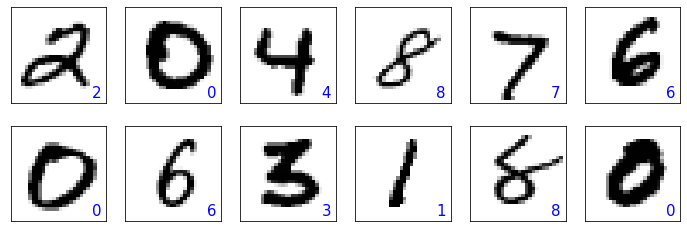

In [22]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()

## 15.4 합성곱 신경망을 사용하여 얼굴 이미지의 성별 분류

In [23]:
import tensorflow as tf
import tensorflow_datasets as tfds

celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)

celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']

In [24]:
def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

In [25]:
print('훈련 데이터셋: {}'.format(count_items(celeba_train)))

훈련 데이터셋: 162770


In [26]:
print('검증 데이터셋: {}'.format(count_items(celeba_valid)))

검증 데이터셋: 19867


In [27]:
print('테스트 데이터셋: {}'.format(count_items(celeba_test)))

테스트 데이터셋: 19962


In [28]:
# 일부만 사용할 것이다. - 대신 증식을 사용할 것이다.
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)

print('훈련 데이터셋 (일부): {}'.format(count_items(celeba_train)))
print('검증 데이터셋 (일부): {}'.format(count_items(celeba_valid)))

훈련 데이터셋 (일부): 16000
검증 데이터셋 (일부): 1000


### 15.4.2 이미지 변환과 데이터 증식

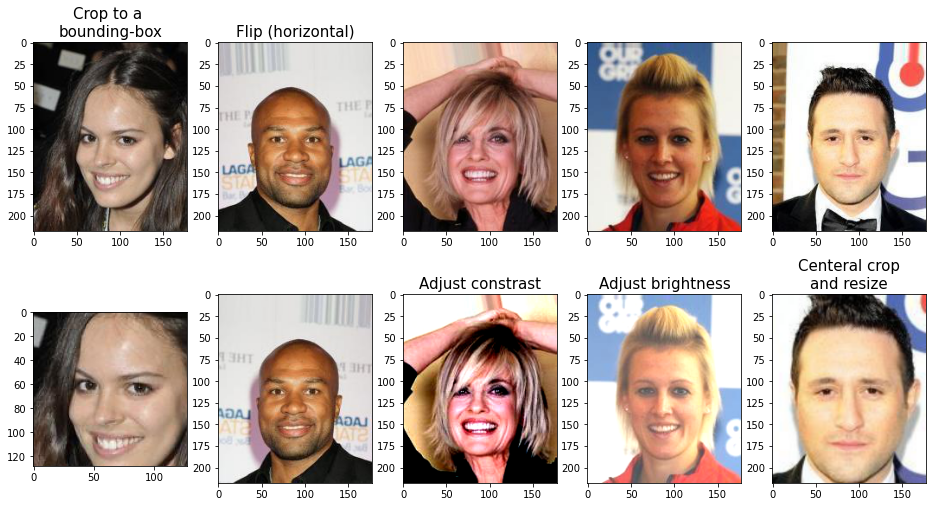

In [29]:
# 데이터 증식의 예
import matplotlib.pyplot as plt
# 다섯 개의 샘플을 가져오기
examples = []
for example in celeba_train.take(5):
    examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))

## 1열: 바운딩 박스로 자르기
ax = fig.add_subplot(2, 5, 1)
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(examples[0])

ax = fig.add_subplot(2, 5, 6)
img_cropped = tf.image.crop_to_bounding_box(
    examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)

## 2열: (수평으로) 뒤집기
ax = fig.add_subplot(2, 5, 2)
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(examples[1])

ax = fig.add_subplot(2, 5, 7)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)

## 3열: 대비 조정
ax = fig.add_subplot(2, 5, 3)
ax.imshow(examples[2])

ax = fig.add_subplot(2, 5, 8)
ax.set_title('Adjust constrast', size=15)
img_adj_contrast = tf.image.adjust_contrast(
    examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

## 4열: 명도 조정
ax = fig.add_subplot(2, 5, 4)
ax.imshow(examples[3])

ax = fig.add_subplot(2, 5, 9)
ax.set_title('Adjust brightness', size=15)
img_adj_brightness = tf.image.adjust_brightness(
    examples[3], delta=0.3)
ax.imshow(img_adj_brightness)

## 5열: 이미지 중앙 자르기
ax = fig.add_subplot(2, 5, 5)
ax.imshow(examples[4])

ax = fig.add_subplot(2, 5, 10)
ax.set_title('Centeral crop\nand resize', size=15)
img_center_crop = tf.image.central_crop(
    examples[4], 0.7)
img_resized = tf.image.resize(
    img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))

plt.show()

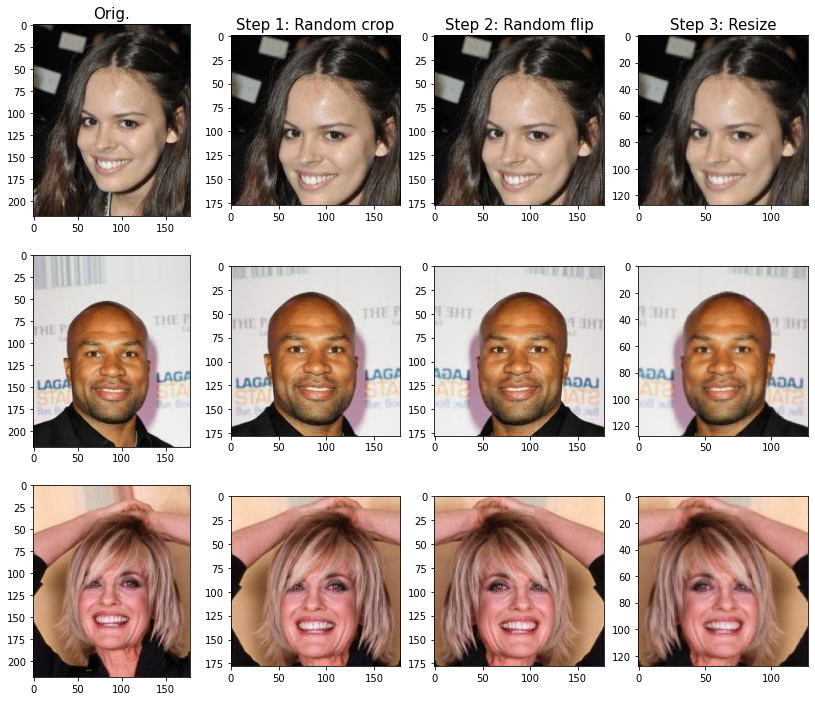

In [30]:
# 증식 방법을 여러개 한 번에 적용
tf.random.set_seed(1)

fig = plt.figure(figsize=(14, 12))

for i,example in enumerate(celeba_train.take(3)):
    image = example['image']

    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title('Orig.', size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)

plt.show()

In [31]:
# 위 데이터 증식 방법을 파이프라인 만들기
# 훈련 데이터셋에만 적용!
def preprocess(example, size=(64, 64), mode='train'):
    image = example['image']
    label = example['attributes']['Male']
    if mode == 'train':
        image_cropped = tf.image.random_crop(
            image, size=(178, 178, 3))
        image_resized = tf.image.resize(
            image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(
            image_resized)
        return image_flip/255.0, tf.cast(label, tf.int32)
    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0,
            target_height=178, target_width=178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return image_resized/255.0, tf.cast(label, tf.int32)

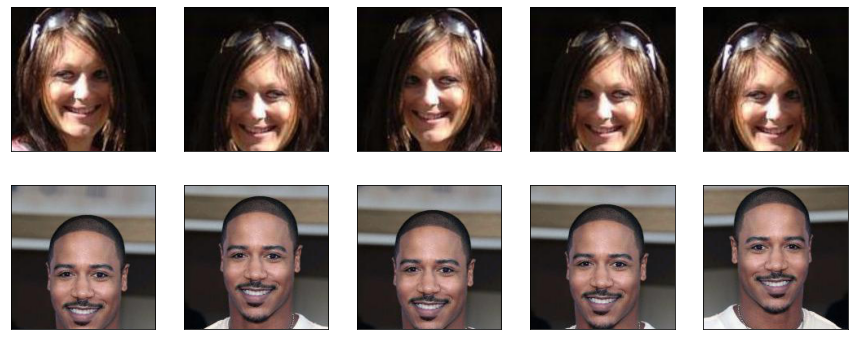

In [32]:
# Example) sample 몇 개를 추출해서 5번 반복하여 적용
tf.random.set_seed(1)
ds = celeba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)
ds = ds.map(lambda x:preprocess(x, size=(178, 178), mode='train'))
fig = plt.figure(figsize=(15, 6))
for j, example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
plt.show()

In [33]:
# Celeb_a 훈련/검증 셋에 적용
import numpy as np
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epochs = np.ceil(16000/BATCH_SIZE)
ds_train = celeba_train.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = celeba_valid.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

### 15.4.3 CNN 성별 분류기 훈련

In [34]:
# 네 개의 합성곱 층, 사이에 풀링 층 (3개), 2개의 드롭 아웃 층
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Conv2D(
        256, (3, 3), padding='same', activation='relu')
])

In [35]:
model.compute_output_shape([None, 64, 64, 3])

TensorShape([None, 8, 8, 256])

In [36]:
# 전역 평균 풀링
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape([None, 64, 64, 3])

TensorShape([None, 256])

In [37]:
# 출력 유닛이 한 개인 완전 연결 층 추가
# 수치적 안정성 때문에 로짓값 그대로 출력
model.add(tf.keras.layers.Dense(1, activation=None))
tf.random.set_seed(1)
model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)      

In [39]:
# 컴파일 & 적합
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=20, steps_per_epoch=steps_per_epochs)

Epoch 1/20
500/500 [==============================] - 89s 176ms/step - loss: 0.6658 - accuracy: 0.5880 - val_loss: 0.5520 - val_accuracy: 0.6860
Epoch 2/20
500/500 [==============================] - 87s 174ms/step - loss: 0.5566 - accuracy: 0.6953 - val_loss: 0.5185 - val_accuracy: 0.6400
Epoch 3/20
500/500 [==============================] - 86s 172ms/step - loss: 0.4956 - accuracy: 0.7402 - val_loss: 0.4169 - val_accuracy: 0.8150
Epoch 4/20
500/500 [==============================] - 88s 175ms/step - loss: 0.4596 - accuracy: 0.7631 - val_loss: 0.3682 - val_accuracy: 0.8230
Epoch 5/20
500/500 [==============================] - 90s 180ms/step - loss: 0.3917 - accuracy: 0.8098 - val_loss: 0.2720 - val_accuracy: 0.8510
Epoch 6/20
500/500 [==============================] - 87s 173ms/step - loss: 0.3369 - accuracy: 0.8406 - val_loss: 0.2187 - val_accuracy: 0.9020
Epoch 7/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2901 - accuracy: 0.8666 - val_loss: 0.1761 - val_ac

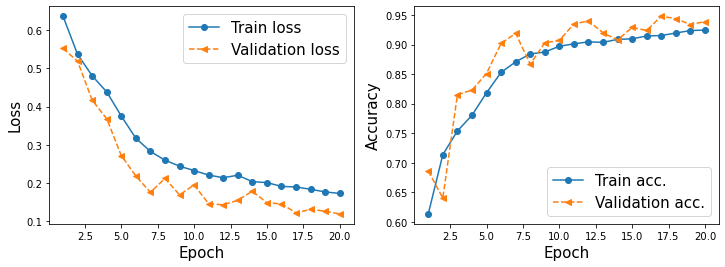

In [40]:
# 손실과 정확도 비교
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [41]:
# 평탄하게 훈련이 잘 안되었다. - 마지막 epoch부터 이어서 훈련할 수 있다.
history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=30, initial_epoch=20,
                    steps_per_epoch=steps_per_epochs)

Epoch 21/30
500/500 [==============================] - 88s 176ms/step - loss: 0.1783 - accuracy: 0.9219 - val_loss: 0.1228 - val_accuracy: 0.9520
Epoch 22/30
500/500 [==============================] - 90s 180ms/step - loss: 0.1682 - accuracy: 0.9272 - val_loss: 0.1315 - val_accuracy: 0.9370
Epoch 23/30
500/500 [==============================] - 88s 176ms/step - loss: 0.1651 - accuracy: 0.9282 - val_loss: 0.1059 - val_accuracy: 0.9530
Epoch 24/30
500/500 [==============================] - 89s 178ms/step - loss: 0.1704 - accuracy: 0.9259 - val_loss: 0.1591 - val_accuracy: 0.9200
Epoch 25/30
500/500 [==============================] - 116s 233ms/step - loss: 0.1600 - accuracy: 0.9328 - val_loss: 0.1068 - val_accuracy: 0.9590
Epoch 26/30
500/500 [==============================] - 91s 182ms/step - loss: 0.1612 - accuracy: 0.9292 - val_loss: 0.1089 - val_accuracy: 0.9600
Epoch 27/30
500/500 [==============================] - 122s 244ms/step - loss: 0.1521 - accuracy: 0.9355 - val_loss: 0.1004

In [43]:
ds_test = celeba_test.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
test_results = model.evaluate(ds_test)
print('테스트 정확도: {:.2f}%'.format(test_results[1]*100))

624/624 [==============================] - 27s 42ms/step - loss: 0.1441 - accuracy: 0.9318
테스트 정확도: 93.18%


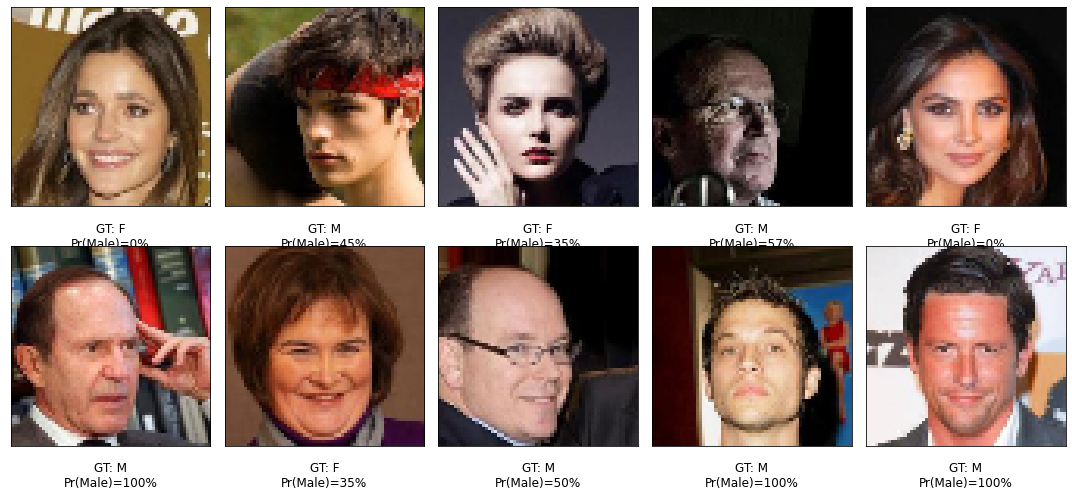

In [45]:
# 테스트 샘플의 예측 결과를 얻기
ds = ds_test.unbatch().take(10)
pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten() * 100
fig = plt.figure(figsize=(15, 7))
for j, example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label = 'M'
    else:
        label = 'F'
    ax.text(
        0.5, -0.15, 'GT: {:s}\nPr(Male)={:.0f}%'
        ''.format(label, probas[j]),
        size=12,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)
plt.tight_layout()
plt.show()